In [107]:
import os
import sys
sys.path.append("..")

In [108]:
os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "0" # "1", "2", "3"


# IPL-VAE: MNIST

In [3]:
import jax
import optax
import distrax
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable
from torchvision.datasets import MNIST

import vae
import ipl_vae as linvae

2022-09-26 08:34:44.780014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-09-26 08:34:44.804349: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-26 08:34:45.458213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-09-26 08:34:45.458329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib


In [4]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [5]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
jnp.set_printoptions(suppress=True, precision=5, linewidth=120)

## Create train dataset

In [208]:
root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [209]:
key = jax.random.PRNGKey(314)
key_fa_param, key_sample, key = jax.random.split(key, 3)
key_vae, key_iplvae = jax.random.split(key)

In [212]:
n_train = 1000
n_test = 500

y_train = jnp.array(mnist_train.targets)

X_train = jnp.array(mnist_train.data)[:n_train + n_test]
X_train = X_train.reshape(-1, 28 ** 2)

y_train = y_train[:n_train + n_test]
dim_output = len(jnp.unique(y_train))

num_train, dim_obs = X_train.shape
# "Gaussanised" MNIST
# X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_test = X_train[-n_test:]
y_test = y_train[-n_test:]
y_ohe_test = y_ohe_train[-n_test:]

X_train = X_train[:-n_test]
y_train = y_train[:-n_test]
y_ohe_train = y_ohe_train[:-n_test]


X_train.shape

(1000, 784)

## IPL - VAE

In [213]:
key_ipl, key_init_params = jax.random.split(key_iplvae, 2)

In [214]:
class FADecoder(nn.Module):
    """
    Parameterise the generative model
    p(x,z) = p(x|z) * p(z)
    as a Factor Analysis (FA) model
    """
    dim_obs: int
    dim_latent: int
    normal_init: Callable = nn.initializers.normal()
    uniform_init: Callable = nn.initializers.uniform()

    
    def setup(self):
        self.b = self.param("b", self.normal_init, (self.dim_obs,))
        self.A = self.param("A", self.normal_init, (self.dim_obs, self.dim_latent))
        # self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs, self.dim_latent))
        self.logPsi = self.param("logPsi", self.normal_init, (self.dim_obs,))


    def eval_mean(self, z):
        mean_x = jnp.einsum("...m,dm->...d", z, self.A)+ self.b
        return mean_x
    
    def eval_diag_cov(self, z):
        # logvar_x = jnp.einsum("...m,dm->...d", z, self.logPsi)

        zeros = jnp.zeros((self.dim_obs, self.dim_latent))
        logvar_x = logvar_x = jnp.einsum("...m,dm->...d", z, zeros) + self.logPsi

        return logvar_x


    def __call__(self, z):
        mean_x = self.eval_mean(z)
        logvar_x = self.eval_diag_cov(z)
        
        return mean_x, logvar_x

    
class Decoder(nn.Module):
    """
    Parameterise the generative model
    p(x,z) = p(x|z) * p(z)
    as a 
    """
    dim_obs: int
    dim_latent: int = 20
    
    @nn.compact
    def __call__(self, z):
        x = nn.Dense(100)(z)
        x = nn.relu(x)
        mean_x = nn.Dense(self.dim_obs)(x)
        logvar_x = nn.Dense(self.dim_obs)(x)
        return mean_x, logvar_x

In [215]:
@partial(jax.vmap, in_axes=(None, None, 1), out_axes=1)
def jmp_part (f, primals, tangents):
    """
    Jacobian Matrix Product (JMP) is the product of
    Jacobian Vector Product (JVP).
    
    We assume f: R^L -> R^M. This operation can be
    computed in in O(L^2) time.
    """
    return jax.jvp(f, (primals,), (tangents,))

def jmp(f, primals, tangents):
    fx, jac_mat = jmp_part(f, primals, tangents)
    return fx[:, 0], jac_mat


@partial(jax.jit, static_argnames='dim')
def fill_lower_tri(v, dim):
    """
    Fill a vector with lower triangular (without diagonal)
    values into a square matrix.

    Source: https://github.com/google/jax/discussions/10146
    """
    idx = jnp.tril_indices(dim, k=-1)
    return jnp.zeros((dim, dim), dtype=v.dtype).at[idx].set(v)

In [235]:
class IPL:
    def __init__(self, prior_mu, prior_Sigma, decoder, n_iterations=1):
        self.prior_mu = prior_mu
        self.prior_Sigma = prior_Sigma
        self.decoder = decoder
        self.num_iterations = n_iterations
        self.dim_obs = decoder.dim_obs
        self.dim_latent = decoder.dim_latent
        self.num_is_samples = 13


    @partial(jax.jit, static_argnums=(0,))
    def lin_predict(self, mu, Sigma, params):
        m, logPsi = self.decoder.apply(params, mu)
        G = jax.jacfwd(lambda x: self.decoder.apply(params, x)[0])(mu)
        Psi = jnp.exp(logPsi) * jnp.eye(self.dim_obs)
        
        S = jnp.einsum("im,mk,jk->ij", G, Sigma, G)
        S = S + Psi
        C = Sigma @ G.T
        
        return m, S, C

    
    def gauss_condition(self, mu_prev, Sigma_prev, y, m, S, C):
        K = jnp.linalg.solve(S, C.T).T
        mu_est = mu_prev + K @ (y - m)

        Sigma_est = jnp.einsum("im,mk,jk->ij", K, S, K)
        Sigma_est = Sigma_prev - Sigma_est

        return mu_est, Sigma_est
    
    
    def iterate_posterior_step(self, state, y, params):
        """
        Iterate posterior step
        """
        mu, Sigma = state
        m, S, C = self.lin_predict(mu, Sigma, params)
        mu_est, Sigma_est = self.gauss_condition(mu, Sigma, y, m, S, C)
        new_state = (mu_est, Sigma_est)
        return new_state, None
    
    
    def estimate_posterior_params(self, y, params):
        state = (self.prior_mu, self.prior_Sigma)
        ips = partial(self.iterate_posterior_step, params=params)
        
        # lax.scan makes it painfully slow
        for it in range(self.num_iterations):
            state, _ = ips(state, y)
            
        post_mu, post_Sigma = state
        return post_mu, post_Sigma
    

    @partial(jax.jit, static_argnums=(0,))
    def compute_iwlmm_single(self, key, obs, params):
        mu, Sigma = self.estimate_posterior_params(obs, params)
        dist_posterior_latent = tfd.MultivariateNormalFullCovariance(mu, Sigma)
        dist_prior_latent = tfd.MultivariateNormalDiag(jnp.zeros(dim_latent), jnp.ones(dim_latent) * 0.9)

        is_samples = dist_posterior_latent.sample(seed=key, sample_shape=self.num_is_samples)
        
        mean_x, logvar_x = self.decoder.apply(params, is_samples)
        
        # cov_x = jax.vmap(jnp.diag)(jnp.exp(logvar_x / 2))
        # dist_decoder = distrax.MultivariateNormalFullCovariance(mean_x, cov_x)

        cov_x = jnp.exp(logvar_x / 2)
        dist_decoder = tfd.MultivariateNormalDiag(mean_x, cov_x)
        

        log_is = (dist_decoder.log_prob(obs)
                + dist_prior_latent.log_prob(is_samples)
                - dist_posterior_latent.log_prob(is_samples))
        
        return jax.nn.logsumexp(log_is, b=1/self.num_is_samples)

## Run process

In [432]:
dim_latent = 50

In [452]:
batch_init = jnp.ones((1, dim_latent))
decoder = FADecoder(dim_obs, dim_latent)


params_decoder = decoder.init(key_init_params, batch_init)

prior_mu, prior_Sigma = jnp.ones(dim_latent), jnp.eye(dim_latent) * 0.9
ipl_vae = IPL(prior_mu, prior_Sigma, decoder, n_iterations=1)

learning_rate = 1e-5
tx = optax.adam(-learning_rate)

tx = optax.chain(
  optax.clip(0.5),
  optax.sgd(-learning_rate),
)


opt_state = tx.init(params_decoder)

In [453]:
def epoch_step(state, xs, gradfn):
    params, opt_state = state
    key, observation = xs
    
    loss, grads = gradfn(key, observation, params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    state = (params, opt_state)
    
    return state, loss

In [454]:
def run_epoch(key, params_init, opt_state, observations, gradfn):
    keys = jax.random.split(key, len(observations))
    xs = (keys, observations)
    state = (params_init, opt_state)
    state, losses = jax.lax.scan(partial(epoch_step, gradfn=gradfn), state, xs)
    return state, losses

In [455]:
samples_observed = X_train

In [473]:
%%time

loss_hist = []
key_epochs = jax.random.split(key_ipl, 80)
gradfn = jax.value_and_grad(ipl_vae.compute_iwlmm_single, argnums=-1)
part_epoch = jax.jit(partial(run_epoch, gradfn=gradfn))

for key in tqdm(key_epochs):
    state_final, loss = part_epoch(key, params_decoder, opt_state, samples_observed)
    params_decoder, opt_state = state_final
    loss = loss.sum()
    print(f"{loss:,.2f}", end="\r")
    loss_hist.append(loss.sum())

  0%|          | 0/80 [00:00<?, ?it/s]

CPU times: user 17.4 s, sys: 2.13 s, total: 19.5 s
Wall time: 3min 50s


## Analysing posterior observations

In [474]:
obs = samples_observed[4]

In [488]:
n_samples = 5
key_choice, keys_is = jax.random.split(key_vae)
keys_is = jax.random.split(keys_is, n_samples)

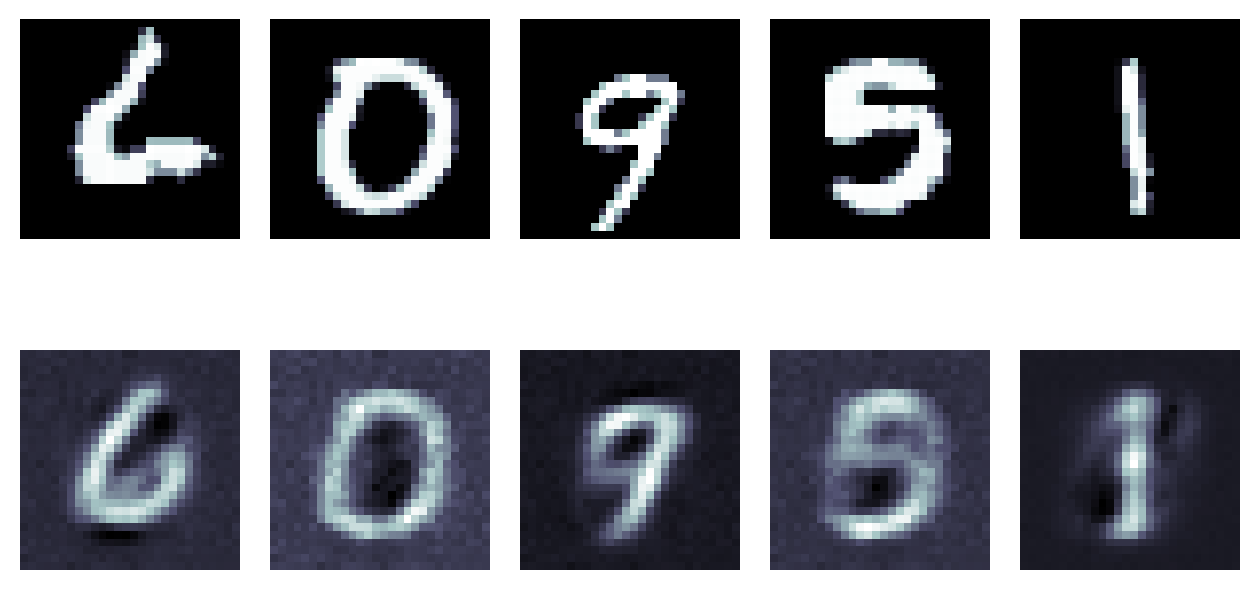

In [489]:
ixs_test = jax.random.choice(key_choice, len(samples_observed), (n_samples,))

fig, ax = plt.subplots(2, n_samples, figsize=(6.4, 4.0))

for ax, ix, key in zip(ax.T, ixs_test, keys_is):
    obs = samples_observed[ix]

    mu, Sigma = ipl_vae.estimate_posterior_params(obs, params_decoder)
    dist_posterior_latent = tfd.MultivariateNormalFullCovariance(mu, Sigma)
    is_samples = dist_posterior_latent.sample(seed=key, sample_shape=1)
    mean_x, logvar_x = ipl_vae.decoder.apply(params_decoder, is_samples)

    ax[0].imshow(obs.reshape(28, 28), cmap="bone")
    ax[1].imshow(mean_x.reshape(28, 28), cmap="bone")
    ax[0].axis("off")
    ax[1].axis("off")
plt.tight_layout()